## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import config
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings

from keras.callbacks import ModelCheckpoint, Callback, TensorBoard
from neural_networks.unet import UNet
from neural_networks.keras_utils import EvalMetricsCallback
from utils.data.data_augmentation import augment16_from_dir_and_save
from utils.data.data_generator import DataGenerator
from utils.data.data_ops import move_val_split_to_train
from utils.data.data_ops import create_val_split_from_train
from utils.input_output.io import read_json, write_json
from utils.visualization.vis import plot_logs

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Load the dataset

#### Create validation split from the initial training data

In [4]:
move_val_split_to_train(config.VAL_PATH, config.TRAIN_PATH)
create_val_split_from_train(config.TRAIN_PATH, config.VAL_PATH, config.VAL_SIZE, config.RAND_SEED)

#### Data augmentation (train/val split)

In [5]:
augment16_from_dir_and_save(in_path=config.TRAIN_PATH,
                            save_path=config.TRAIN_PATH,
                            rseed=config.RAND_SEED)

augment16_from_dir_and_save(in_path=config.VAL_PATH,
                            save_path=config.VAL_PATH,
                            rseed=config.RAND_SEED + 1)

#### Data generators

In [6]:
train_params = {
    'dim': config.PATCH_DIM,
    'batch_size': config.BATCH_SIZE,
    'patches_per_image': config.PATCHES_PER_IMAGE,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': config.SHUFFLE,
    'ignored_images': config.IGNORED_IMAGES,
    'data_augmentation': True
}

val_params = {
    'dim': config.IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': config.DENSITY_MAP_MULTIPLICATION_FACTOR,
    'shuffle': False,
    'data_augmentation': True
}

eval_params = val_params.copy()

In [7]:
train_generator = DataGenerator(config.DATASET_PATH, 'train', **train_params)
val_generator = DataGenerator(config.DATASET_PATH, 'val', **val_params)

### for eval
train_generator_for_eval = DataGenerator(config.DATASET_PATH, 'train', **eval_params)
val_generator_for_eval = DataGenerator(config.DATASET_PATH, 'val', **eval_params)

## 3. Instantiate a UNet

In [8]:
model = UNet(loss_name=config.LOSS_NAME, learning_rate=config.LEARNING_RATE)

## 4. Train the model

In [9]:
!rm -rf $config.CHECKPOINTS_PATH
!rm -rf $config.LOGS_PATH
os.makedirs(config.CHECKPOINTS_PATH)
os.makedirs(config.LOGS_PATH)

In [10]:
%%time
'''
eval_metrics_callback = EvalMetricsCallback(config.DENSITY_MAP_MULTIPLICATION_FACTOR,
                                            train_generator_for_eval,
                                            val_generator_for_eval)

tensorboard_checkpoint = TensorBoard(log_dir=config.LOGS_PATH + 'tensorboard',
                                     write_graph=False,
                                     update_freq='batch')
'''
model_checkpoint = ModelCheckpoint(config.CHECKPOINT_FILENAME,
                                   monitor='val_loss',
                                   save_best_only=True)

model_history = model.fit_generator(generator=train_generator,
                                    validation_data=val_generator,
                                    epochs=config.EPOCHS,
                                    callbacks=[model_checkpoint],
                                    verbose=1)

Epoch 1/30
256/256 [==============================] - 50s 196ms/step - loss: 0.0161 - val_loss: 0.0107
Epoch 2/30
256/256 [==============================] - 45s 178ms/step - loss: 0.0060 - val_loss: 0.0060
Epoch 3/30
256/256 [==============================] - 65s 253ms/step - loss: 0.0050 - val_loss: 0.0058
Epoch 4/30
256/256 [==============================] - 61s 240ms/step - loss: 0.0047 - val_loss: 0.0054
Epoch 5/30
256/256 [==============================] - 46s 179ms/step - loss: 0.0043 - val_loss: 0.0051
Epoch 6/30
256/256 [==============================] - 46s 179ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 7/30
256/256 [==============================] - 46s 180ms/step - loss: 0.0041 - val_loss: 0.0048
Epoch 8/30
256/256 [==============================] - 46s 181ms/step - loss: 0.0039 - val_loss: 0.0046
Epoch 9/30
256/256 [==============================] - 46s 181ms/step - loss: 0.0038 - val_loss: 0.0047
Epoch 10/30
256/256 [==============================] - 47s 182ms/step - l

#### Save and load train stats/logs/history

In [11]:
logs = model.history.history.copy()

logs['train_loss'] = logs.pop('loss')
logs['train_size'] = train_generator.get_size()
logs['val_size'] = val_generator.get_size()
logs['rand_seed'] = config.RAND_SEED
logs['shuffle'] = config.SHUFFLE
logs['loss_name'] = config.LOSS_NAME
logs['img_dim'] = config.IMG_DIM
logs['patch_dim'] = config.PATCH_DIM
logs['patches_per_image'] = config.PATCHES_PER_IMAGE
logs['density_map_sigma'] = config.GT_SIGMA
logs['density_map_multiplication_factor'] = config.DENSITY_MAP_MULTIPLICATION_FACTOR
logs['sub_experiment_name'] = config.SUB_EXPERIMENT_NAME
logs['architecture'] = config.ARCHITECTURE_NAME

min val_loss: 0.0040, epoch: 30


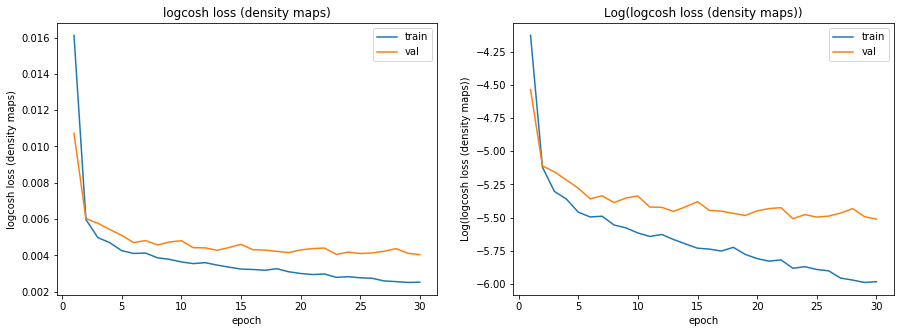

"\nplot_logs(logs['train_mae'], logs['val_mae'], f'Mean_absolute_error (counts)')\nplot_logs(logs['train_rmse'], logs['val_rmse'], f'RMSE (counts)')\nplot_logs(logs['train_underestimate'], logs['val_underestimate'], f'Underestimate (% from GT counts)')\nplot_logs(logs['train_overestimate'], logs['val_overestimate'], f'Overestimate (% from GT counts)')\nplot_logs(logs['train_difference'], logs['val_difference'], f'Difference (% from GT counts)')\n"

In [12]:
write_json(logs, config.LOGS_FILENAME)
logs = read_json(config.LOGS_FILENAME)

print(f'min val_loss: {np.min(logs["val_loss"]):.4f}, epoch: {1 + np.argmin(logs["val_loss"])}')

plot_logs(logs['train_loss'], logs['val_loss'], f'{config.LOSS_NAME} loss (density maps)')
'''
plot_logs(logs['train_mae'], logs['val_mae'], f'Mean_absolute_error (counts)')
plot_logs(logs['train_rmse'], logs['val_rmse'], f'RMSE (counts)')
plot_logs(logs['train_underestimate'], logs['val_underestimate'], f'Underestimate (% from GT counts)')
plot_logs(logs['train_overestimate'], logs['val_overestimate'], f'Overestimate (% from GT counts)')
plot_logs(logs['train_difference'], logs['val_difference'], f'Difference (% from GT counts)')
'''